# Ultimate Data Science Challenge

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
# from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
import json
from pandas.io.json import json_normalize

# Part I : Exploratory Data Analysis

__Let's visualize the login counts by binning the data in 15 minutes time intervals.__

Clean the data first

In [77]:
#Extract the data
df = pd.read_json('logins.json')
print (len(df))
print (df.login_time.dtypes)
df.describe()

93142
datetime64[ns]


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [119]:
#Convert to timeseries and counts
ts = pd.DataFrame(index=df.login_time,columns=['count'])
ts['count'] = 1
# ts.isnull().sum()

In [120]:
#Aggregate to 15 minute intervals
ts = ts.resample('15T').sum()

print ("sum of logins -",ts['count'].sum())
print(len(ts))
print(ts.dtypes)
print ("Null values -",ts.isnull().sum())
ts.describe()

sum of logins - 93142.0
9788
count    float64
dtype: object
Null values - count    407
dtype: int64


,count
count,9381.000000
mean,9.928792
std,8.263146
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,73.000000


## Descriptive Statistics

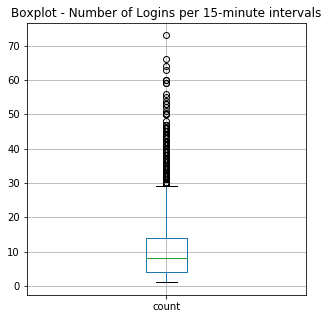

In [113]:
fig = plt.figure(figsize=(5,5))
plt.title("Boxplot - Number of Logins per 15-minute intervals")
ts.boxplot('count')

The median is about 8 logins per 15-minute-interval but the data is skewed according to the boxplot, with many outliers with more than 30 logins. We have to explore further to find out if there are specific times of the day when this happens.

**Let's investigate for the daily variation.**

To do that, we remove the date information from the data and aggregate it to the 15-minute time interval to see the aggregate daily variation.

In [101]:
dailycount = pd.DataFrame.copy(ts)

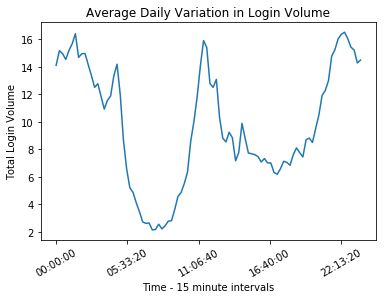

In [102]:
dailycount.index = dailycount.index.time
temp = dailycount.groupby(dailycount.index).mean()

fig = plt.figure(figsize=(6,4))
plt.plot(temp)
plt.xticks(rotation=30)
plt.title("Average Daily Variation in Login Volume")
plt.xlabel("Time - 15 minute intervals")
plt.ylabel("Total Login Volume")

** So by observing the daily cycles, we can see that more people tend to login late at night and around the lunch-time. **

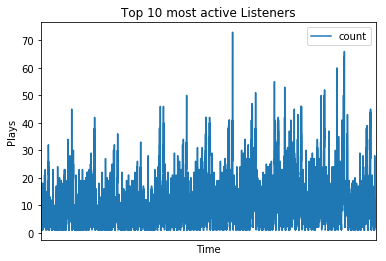

In [124]:
fig = plt.figure(figsize=(10,5))
ts.plot() #or other function
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.ylabel("Plays")
plt.xlabel("Time")
plt.title("Top 10 most active Listeners")

** Plotting the data as it is on 15-minute aggregation is difficult to visualize, so let's analyze the data by aggregating further in different ways. **

## Aggregations

Let's quickly visualize other levels of variations such as the following -

### Day-of-the-week

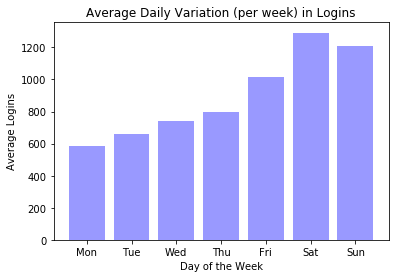

In [125]:
ts = ts.resample('D').sum() #Sum of all the logins in a day
temp = ts.groupby(ts.index.dayofweek).mean() # Group by day of the week

fig = plt.figure(figsize=(6,4))
plt.bar(temp.index,list(temp['count']),color='b',alpha=0.4)
plt.title("Average Daily Variation (per week) in Logins")
plt.xticks([i for i in range(7)],["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Average Logins")

** This shows that the login count (demand) is least on Monday, which goes on increasing towards the weekend, peaks out on Saturday and reduced a little bit on Sunday. **

### Day-of-month

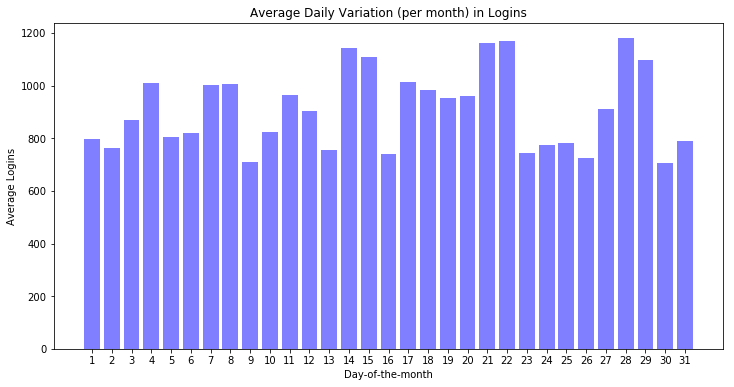

In [126]:
ts = ts.resample('D').sum() #Sum of all the logins in a day
temp = ts.groupby(ts.index.day).mean() # Group by day of the week

fig = plt.figure(figsize=(12,6))
plt.bar(temp.index,list(temp['count']),color='b',alpha=0.5)
plt.title("Average Daily Variation (per month) in Logins")
plt.xticks([i+1 for i in range(31)],[i+1 for i in range(31)])
plt.xlabel("Day-of-the-month")
plt.ylabel("Average Logins")

### Month-of-year

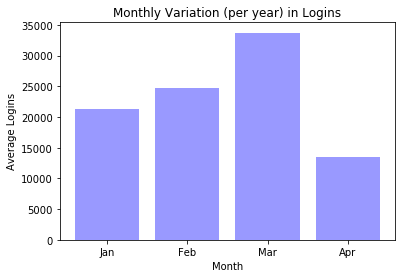

In [129]:
ts = ts.resample('M').sum() #Sum of all the logins in a day
temp = ts.groupby(ts.index.month).mean() # Group by day of the week

fig = plt.figure(figsize=(6,4))
plt.bar(temp.index,list(temp['count']),color='b',alpha=0.4)
plt.title("Monthly Variation (per year) in Logins")
plt.xticks([i+1 for i in range(4)],["Jan","Feb","Mar","Apr"])
plt.xlabel("Month")
plt.ylabel("Average Logins")

## Trend

Now, if we aggregate on montly level and then plot the whole data, the trend become much easier to observe.

### Year-by-year trend (Monthly Aggregation)

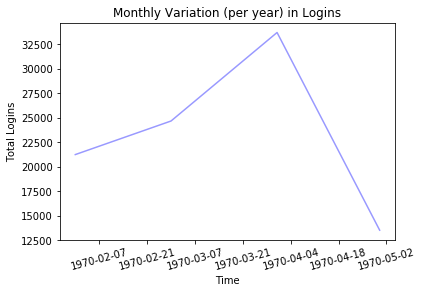

In [137]:
temp = ts.resample('M').sum() #Sum of all the logins in a day

fig = plt.figure(figsize=(6,4))
plt.plot(temp,color='b',alpha=0.4)
plt.xticks(rotation=15)
plt.title("Monthly Variation (per year) in Logins")
# plt.xticks([i+1 for i in range(4)],["Jan","Feb","Mar","Apr"])
plt.xlabel("Time")
plt.ylabel("Total Logins")

# Part II : Experiment and metrics Design

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The obvious expected outcome of the plan would mean increase in the collection of toll, which could be used to build a good quantifiable measure of success. If there is reliable data available on the numbers of existing driver partners in each of the cities, it can be used along with the toll collection data to define a metric to measure the success.

So, the measure could be

*Increase in number of vehicles passing through the toll booth on both sides per week (or some other time period)*

**or**

*Ratio of increase in number of vehicles passing through the toll booth on both sides per week to the number of weekly active driver partners in each city*

We can have separate metric for each city, and an aggregate metric as well.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

#### Experiment Overview

*Assumption - Driver partners are completely exclusive to each city*

Collect the data about number of vehicles passing through the toll booths in a certain period of days before and after the plan is implemented. The data can be used to perform a hypothesis test (A/B testing) -

*Null Hypothesis - There is no change in the number of vehicles passing*

** Important Considerations -**

* While deciding the time-period for data collection
    * Conduct two separate experiments for weekdays and weekends, one for the weekends because the cities behave similar of weekends (something we could ideally want to be always true for consistancy) and second for the weekdays because the cities behave completely complimentary on the weekends
    * Choosing two different dates for the data collection are crutial as well. We can to account for festivals, seasons or any other spacial events and make sure to minimize the external factors that can influence our data collection to make sure that the experiment is as isolated from externalities as possible.
    
    
** Take Aways from the experiment - **

    If the null hypothesis is rejected by a good margin -

Use the value of increase in vehicle traffic to define the metric and continue data collection to minimize the error. Finally, quantify and monitor the usefulness of the plan.

    If null hypothesis cannot be rejected -

We have to conclude that the plan is failed

    If null hypothesis is in the grey area -

Build a better statistical test (gather more data, gather more consistent data, take steps to account for environmental changes such as increase in the number of vehicles, increase in the populations and other socio-economical factors that may have an effect on vehicle traffic)

# Predictive Analysis

In [221]:
# import data
with open('ultimate_data_challenge.json', 'r') as datafile:
        data = json.load(datafile)
df = pd.DataFrame(data)
# df.head()

In [222]:
#convert dtype to datetime
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

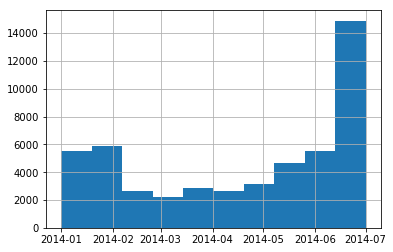

In [212]:
df.last_trip_date.hist()

## Defining 'Retention'

Regarding the definition of retention -

Let's refer to the given definition (user is considered up to 30 days after the last login) and use it to define a binary 'retention' class based on given data. As we are only given the information about 'last_trip_date' and 'signup_date', I used the following approach to define retention based on the 30-day criteria -

1. **Defined 'last_activity_date' as last_trip_days + 30 days. For example, if a user took a trip on August 1st 2017, he will be considered as an active user until 30 days after August 1st.**

2. **Then, I use this definition to check if the user was 'active' in their 6th month, by taking timedelta and assign a binary class using the 6 month threshold.**

In [223]:
retention = []
df['last_activity_date'] = 30
df['last_activity_date'] = df['last_trip_date'] + df['last_activity_date'].values.astype("timedelta64[D]")
df[['last_activity_date','last_trip_date']].head()

for i in range(len(df)):
    
    if df.last_activity_date.iloc[i] - df.signup_date.iloc[i] <= pd.Timedelta('150d'):
        retention.append(0)
    else:
        retention.append(1)

retention[:10]

[1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

** Drop the Dates **

In [224]:
df['retention'] = retention
df = df.drop('last_activity_date',axis=1)

In [225]:
df = df.drop(['last_trip_date','signup_date'],axis=1)

#### Types of features

In [226]:
categorical = ['city','phone']
numerical = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']
boolean = ['ultimate_black_user']

### Null Values
Let's skip imputation and delete the rows with missing values for convinience

In [227]:
cols = list(df.columns)
for column in cols:
    missing_count = df[column].isnull().values.sum()
    print (column, " - ", missing_count)

    if missing_count > 0:
        null_cols.append(column)
        df = df.loc[df[column].notnull()]
    
    missing_count = df[column].isnull().values.sum()
    print (column, " - ", missing_count,'\n')

avg_dist  -  0
avg_dist  -  0 

avg_rating_by_driver  -  201
avg_rating_by_driver  -  0 

avg_rating_of_driver  -  8055
avg_rating_of_driver  -  0 

avg_surge  -  0
avg_surge  -  0 

city  -  0
city  -  0 

phone  -  299
phone  -  0 

surge_pct  -  0
surge_pct  -  0 

trips_in_first_30_days  -  0
trips_in_first_30_days  -  0 

ultimate_black_user  -  0
ultimate_black_user  -  0 

weekday_pct  -  0
weekday_pct  -  0 

retention  -  0
retention  -  0 



### Encoding Categorical and Boolean Variables

In [228]:
for i in categorical:
    print (df[i].value_counts())

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64
iPhone     29352
Android    12093
Name: phone, dtype: int64


In [230]:
from sklearn.preprocessing import LabelEncoder

#Categorical Encoding

df = df.loc[(df.phone == 'iPhone') | (df.phone == 'Android')] # clean phone column
    
    
for column in categorical:
    
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [231]:
le = LabelEncoder() #boolean encoding
df['ultimate_black_user'] = le.fit_transform(df['ultimate_black_user'])

### Train Test Split

In [196]:
features = df.drop('retention',axis=1)

In [197]:
from sklearn.model_selection import train_test_split
X, Xtest, y, ytest = train_test_split(features, df['retention'],random_state=1,test_size=0.7)

### Define Evaluation Functions

In [198]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, recall_score

In [199]:
def roccurve(trainedevaluator,plotting=True,X=X,y=y,Xtest=Xtest,ytest=ytest):
    """ Plots ROC Curve and return area under the curve """
    
    #fit
    trainedevaluator.fit(X,y)
    
    #Find probabilities
    preds = trainedevaluator.predict_proba(Xtest)[:,1]
    
    #ROC
    fpr, tpr, _ = roc_curve(ytest, preds)
    
    #Area Under the curve
    area = auc(fpr,tpr)
    
    #Plot
    if plotting == True:
        plt.figure(figsize=(6,6))
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title("ROC",fontsize=12)
        plt.xlabel("False Positive Rate")
        plt.ylabel("Ttrue Positive Rate")
        plt.plot(fpr,tpr)
        plt.plot([0,1],[0,1],'--',alpha=0.5)
    
    return area

In [200]:
def prediction(clf,X=X,y=y,Xtest=Xtest,ytest=ytest):
    clf.fit(X.values, y.values)
    preds = clf.predict(Xtest)
    cm = confusion_matrix(ytest, preds)
    
    print ("\nClassification Report on the Training data -\n", classification_report(y, clf.predict(X)))
    
    print("Accuracy Score =", accuracy_score(ytest, preds))
    print("Recall Score = ", recall_score(ytest,preds))
    
    print("\nConfusion Matrix -\n",cm)
    print("\nClassification Report -\n",classification_report(ytest, preds))
    try:
        print("Area under the ROC curve = {}".format(roccurve(clf)))
    except AttributeError:
        print ("Cannot draw ROC - predict_proba is not an attribute")

## Prediction

In [132]:
from sklearn.ensemble import RandomForestClassifier


Classification Report on the Training data -
              precision    recall  f1-score   support

          0       0.75      0.80      0.77      6360
          1       0.77      0.72      0.74      6073

avg / total       0.76      0.76      0.76     12433

Accuracy Score = 0.75041362195
Recall Score =  0.700511218404

Confusion Matrix -
 [[11905  3023]
 [ 4218  9866]]

Classification Report -
              precision    recall  f1-score   support

          0       0.74      0.80      0.77     14928
          1       0.77      0.70      0.73     14084

avg / total       0.75      0.75      0.75     29012

Area under the ROC curve = 0.8312343155125289


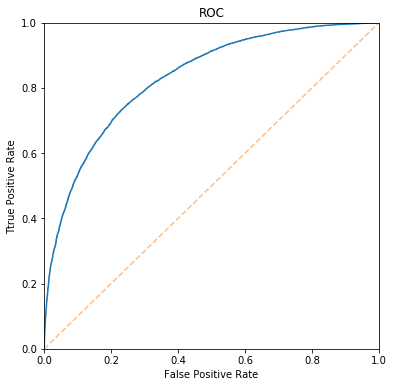

In [207]:
#Initial Run
rf = RandomForestClassifier(n_estimators=100, min_samples_split=200)
rf.fit(X,y)

prediction(rf)

### Feature Importances

(-1, 10)

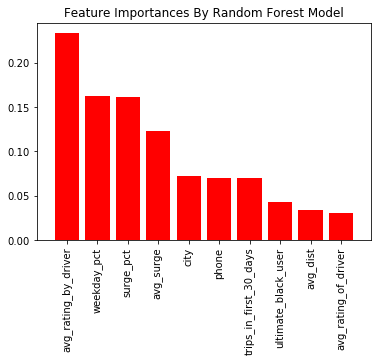

In [208]:
predictors = list(features.columns)

importances=rf.feature_importances_

indices = np.argsort(importances)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
    
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])

We have been able to predict retention in the 6th month at an accuracy of 75%. This can be improved further.

We also have found the top features that help the prediction which are displayed in the bar chart above, and the top 3 factors are as follows -

* Average Rating given to the rider by driver - We can say that better riders are more likely to stay
* Percent of user's trips during workday - We can conclude that people who use rides presumably to go to work are likely to stay
* Percent of trips taken with surge multiplyer - We can safely assume that people who experience surge pricing more frequently are less likely to stay